In [63]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import metrics
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle

In [64]:
train_data = pd.read_excel('Data_Train.xlsx')
train_data.dropna(inplace=True)
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [65]:
train_data['Destination'].value_counts()

Destination
Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: count, dtype: int64

In [66]:
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x

train_data['Destination'] = train_data['Destination'].apply(newd)
train_data['Source'] = train_data['Source'].apply(newd)

In [67]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1.2+ MB


In [68]:
train_data['Journey_day'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.day
train_data['Journey_month'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.month

train_data.drop('Date_of_Journey',inplace=True,axis=1)

train_data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [69]:
train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
train_data.drop('Dep_Time',axis=1,inplace=True)

train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
train_data.drop('Arrival_Time',axis=1,inplace=True)
train_data.head()

<ipython-input-69-ad406d18b393>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
<ipython-input-69-ad406d18b393>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
<ipython-input-69-ad406d18b393>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
<ipython-input-69-ad406d18b393>:6: UserWarning: Could not infer format, so each element will be parsed individua

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [70]:
duration = list(train_data['Duration'])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]

duration_hour = []
duration_min = []

for i in duration:
    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))


train_data['Duration_hours'] = duration_hour
train_data['Duration_mins'] = duration_min
train_data.drop('Duration',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


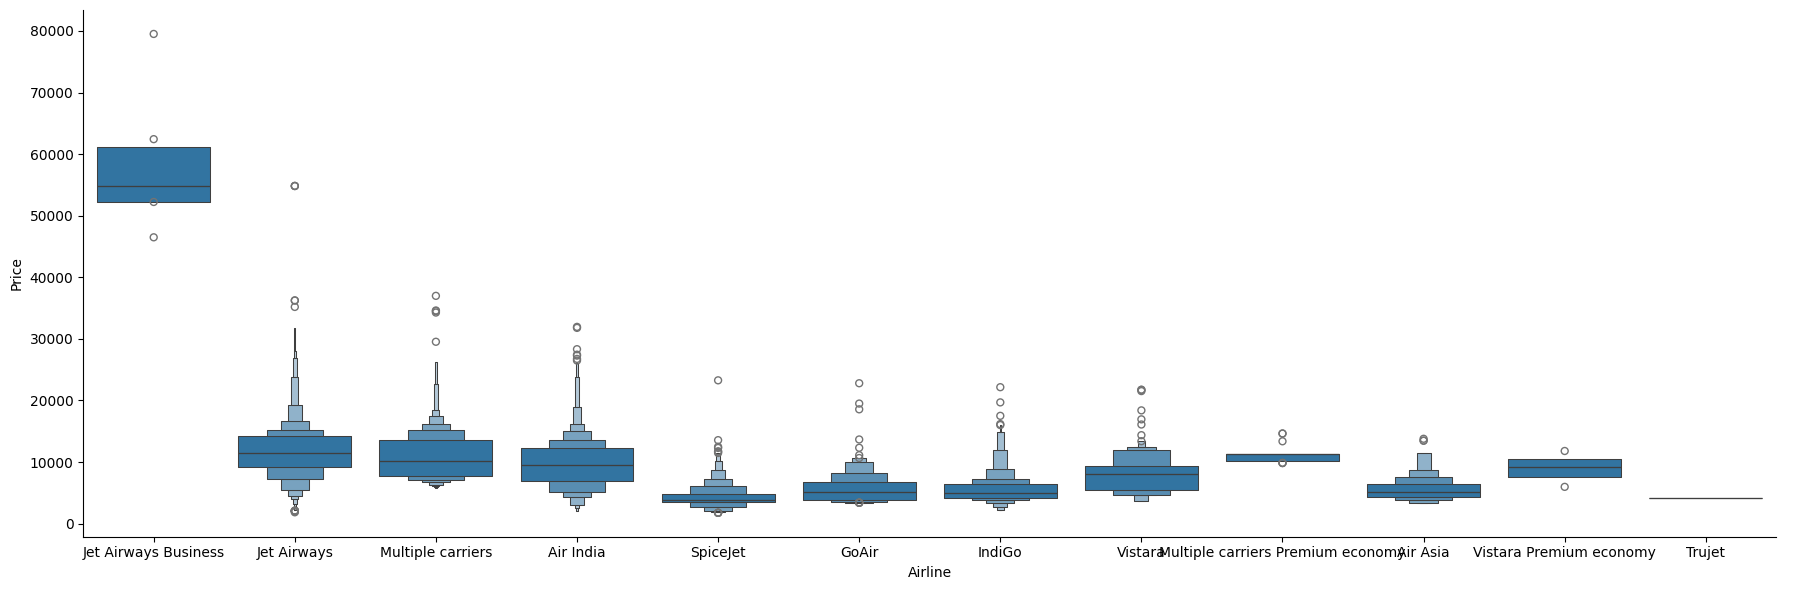

In [71]:
# we can observe that jet airways bussiness is he costliest airways
sns.catplot(x='Airline',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6)

In [72]:
airline = train_data[['Airline']]
airline = pd.get_dummies(airline,drop_first=True)

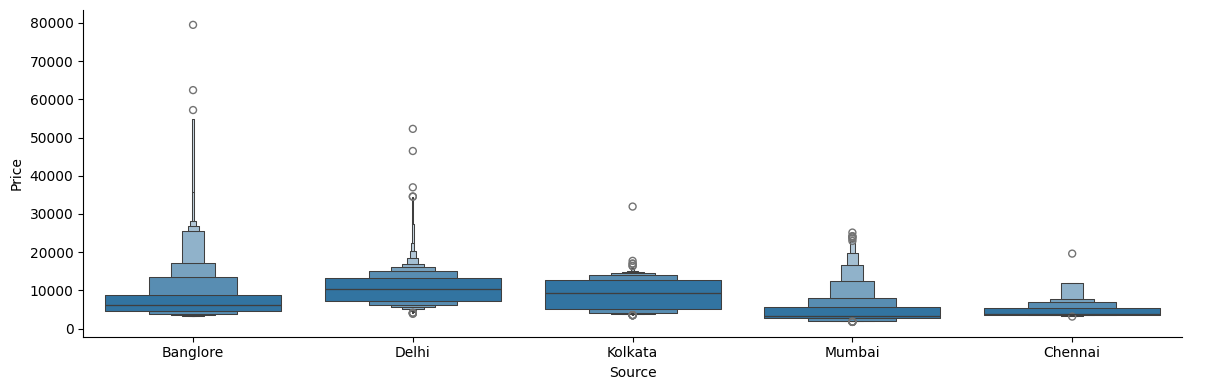

In [73]:
# If we are going from Banglore the prices are slightly higher as compared to other cities
sns.catplot(x='Source',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [74]:
source = train_data[['Source']]
source = pd.get_dummies(source,drop_first=True)
source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,False,False,False,False
1,False,False,True,False
2,False,True,False,False
3,False,False,True,False
4,False,False,False,False


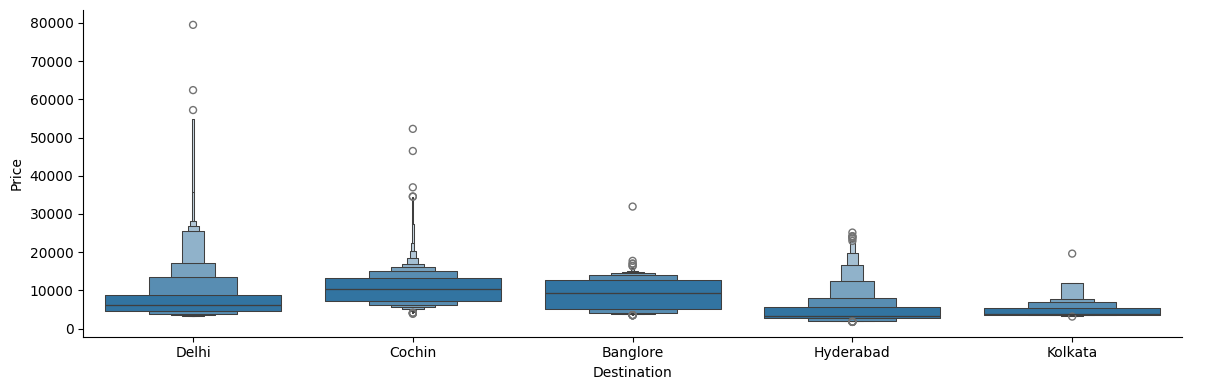

In [75]:
# If we are going to New Delhi the prices are slightly higher as compared to other cities
sns.catplot(x='Destination',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [76]:
destination = train_data[['Destination']]
destination = pd.get_dummies(destination,drop_first=True)
destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,False,True,False,False
1,False,False,False,False
2,True,False,False,False
3,False,False,False,False
4,False,True,False,False


In [77]:
train_data.drop(['Route','Additional_Info'],inplace=True,axis=1)

In [78]:
train_data['Total_Stops'].value_counts()

Total_Stops
1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: count, dtype: int64

In [79]:
# acc to the data, price is directly prop to the no. of stops
train_data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1,13302,1,3,16,50,21,35,4,45


In [80]:
print(airline.shape)
print(source.shape)
print(destination.shape)
print(train_data.shape)

(10682, 11)
(10682, 4)
(10682, 4)
(10682, 13)


In [81]:
data_train = pd.concat([train_data,airline,source,destination],axis=1)
data_train.drop(['Airline','Source','Destination'],axis=1,inplace=True)
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,...,False,False,False,False,False,False,False,True,False,False
1,2,7662,1,5,5,50,13,15,7,25,...,False,False,False,False,True,False,False,False,False,False
2,2,13882,9,6,9,25,4,25,19,0,...,False,False,False,True,False,False,True,False,False,False
3,1,6218,12,5,18,5,23,30,5,25,...,False,False,False,False,True,False,False,False,False,False
4,1,13302,1,3,16,50,21,35,4,45,...,False,False,False,False,False,False,False,True,False,False


# Feature Selection

Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods,

1. **heatmap**
2. **feature_importance_**
3. **SelectKBest**

In [82]:
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata'],
      dtype='object')

In [83]:
X = data_train.drop('Price',axis=1)
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,24,3,22,20,1,10,2,50,False,...,False,False,False,False,False,False,False,True,False,False
1,2,1,5,5,50,13,15,7,25,True,...,False,False,False,False,True,False,False,False,False,False
2,2,9,6,9,25,4,25,19,0,False,...,False,False,False,True,False,False,True,False,False,False
3,1,12,5,18,5,23,30,5,25,False,...,False,False,False,False,True,False,False,False,False,False
4,1,1,3,16,50,21,35,4,45,False,...,False,False,False,False,False,False,False,True,False,False


In [84]:
y = data_train['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

In [85]:
reg = ExtraTreesRegressor()
reg.fit(X,y)

print(reg.feature_importances_)

[2.56581840e-01 1.42199936e-01 5.85747191e-02 2.38601903e-02
 2.14254999e-02 2.86704434e-02 1.92075870e-02 1.05841221e-01
 1.77631620e-02 8.92957781e-03 1.93720500e-03 2.03085566e-02
 1.36453813e-01 6.74409846e-02 1.92376394e-02 8.46533643e-04
 5.83078322e-03 1.26598601e-04 4.40312656e-03 6.09125317e-05
 7.45667984e-04 9.15659111e-03 4.53463537e-03 6.91331730e-03
 1.03791385e-02 1.82670564e-02 9.67763721e-03 6.25627114e-04]


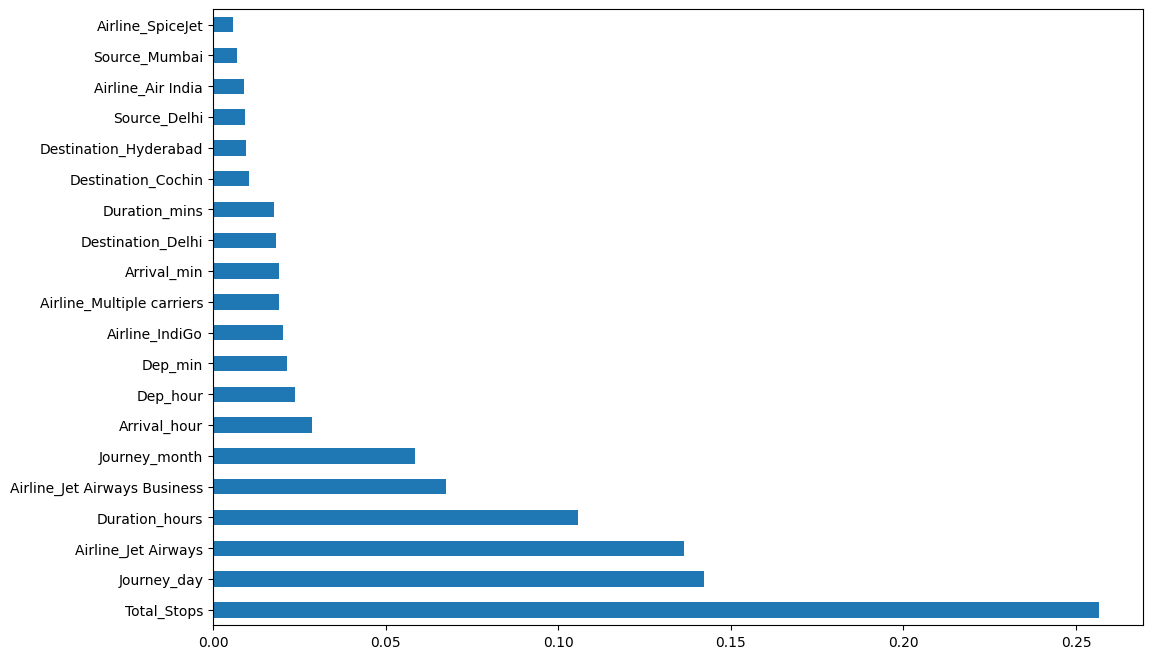

In [86]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# Fitting model using Random Forest
1. Split dataset into train and test set in order to prediction w.r.t X_test
2. If needed do scaling of data(Scaling is not done in Random forest)
3. Import model
4. Fit the data
5. Predict w.r.t X_test
6. In regression check RSME Score
7. Plot graph

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Training Accuracy (Random Forest Regressor): 88.79%
Testing Accuracy (Random Forest Regressor): 80.22%


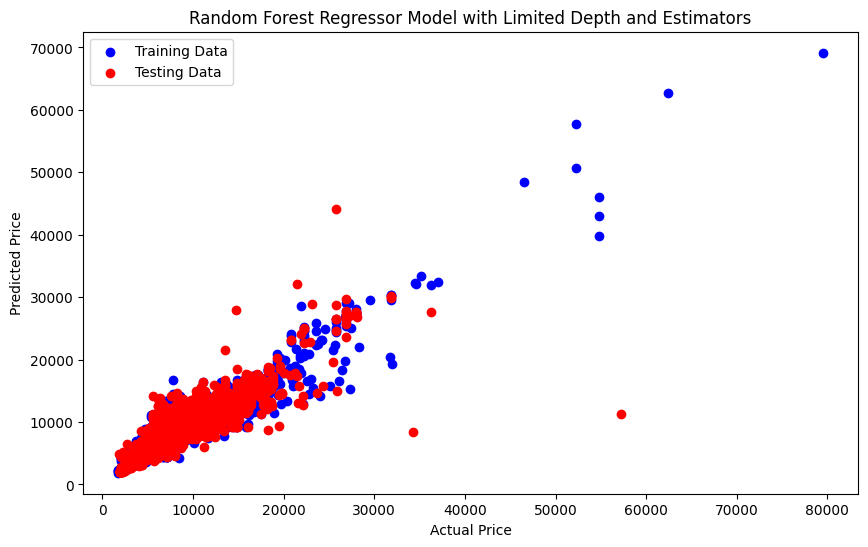

In [88]:









\










































































\
























from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Initialize Random Forest Regressor model with limited depth and number of estimators
rf_model = RandomForestRegressor(n_estimators=190, max_depth=10, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predictions on training and testing data
train_predictions_rf = rf_model.predict(X_train)
test_predictions_rf = rf_model.predict(X_test)

# Calculate R^2 scores for training and testing data
train_r2_score_rf = r2_score(y_train, train_predictions_rf)
test_r2_score_rf = r2_score(y_test, test_predictions_rf)

# Convert R^2 scores to accuracy in percentage form
train_accuracy_percentage_rf = train_r2_score_rf * 100
test_accuracy_percentage_rf = test_r2_score_rf * 100

print(f'Training Accuracy (Random Forest Regressor): {train_accuracy_percentage_rf:.2f}%')
print(f'Testing Accuracy (Random Forest Regressor): {test_accuracy_percentage_rf:.2f}%')

# Plotting
plt.figure(figsize=(10, 6))

# Plotting training data
plt.scatter(y_train, train_predictions_rf, color='blue', label='Training Data')

# Plotting testing data
plt.scatter(y_test, test_predictions_rf, color='red', label='Testing Data')

plt.title('Random Forest Regressor Model with Limited Depth and Estimators')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()




In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluation Metrics for Random Forest Regressor
def evaluate_random_forest_regressor(y_true, y_pred):
    # Calculate Relative Absolute Error (RAE)
    def relative_absolute_error(y_true, y_pred):
        abs_err = np.abs(y_true - y_pred)
        return np.sum(abs_err) / np.sum(np.abs(y_true - np.mean(y_true)))

    # Calculate Mean Absolute Percentage Error (MAPE)
    def mean_absolute_percentage_error(y_true, y_pred):
        abs_percentage_err = np.abs((y_true - y_pred) / y_true)
        return np.mean(abs_percentage_err) * 100

    # Calculate Root Mean Squared Error (RMSE)
    def root_mean_squared_error(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    # Calculate Relative Squared Error (RSE)
    def relative_squared_error(y_true, y_pred):
        return mean_squared_error(y_true, y_pred) / np.mean((y_true - np.mean(y_true))**2)

    # Calculate Normalized Root Mean Squared Error (NRMSE)
    def normalized_root_mean_squared_error(y_true, y_pred):
        return root_mean_squared_error(y_true, y_pred) / (np.max(y_true) - np.min(y_true))

    # Calculate Relative Root Mean Squared Error (RRMSE)
    def relative_root_mean_squared_error(y_true, y_pred):
        return np.sqrt(relative_squared_error(y_true, y_pred))

    # Calculate evaluation metrics
    rae = relative_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    rse = relative_squared_error(y_true, y_pred)
    nrmse = normalized_root_mean_squared_error(y_true, y_pred)
    rrmse = relative_root_mean_squared_error(y_true, y_pred)

    # Print the results
    print(f'Relative Absolute Error (RAE): {rae}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Relative Squared Error (RSE): {rse}')
    print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse}')
    print(f'Relative Root Mean Squared Error (RRMSE): {rrmse}')

# Evaluate Random Forest Regressor
evaluate_random_forest_regressor(y_test, test_predictions_rf)


Relative Absolute Error (RAE): 0.3484056380504603
Mean Absolute Percentage Error (MAPE): 14.445497783317615
Mean Squared Error (MSE): 3971521.415946031
Root Mean Squared Error (RMSE): 1992.8676363336403
Relative Squared Error (RSE): 0.19784906244296868
Normalized Root Mean Squared Error (NRMSE): 0.03599248020252561
Relative Root Mean Squared Error (RRMSE): 0.4448022734237862


# Save the model to reuse it again

In [90]:
file = open('flight_rf.pkl', 'wb')
pickle.dump(rf_model, file)

Training Accuracy (Linear Regression): 61.11%
Testing Accuracy (Linear Regression): 60.94%


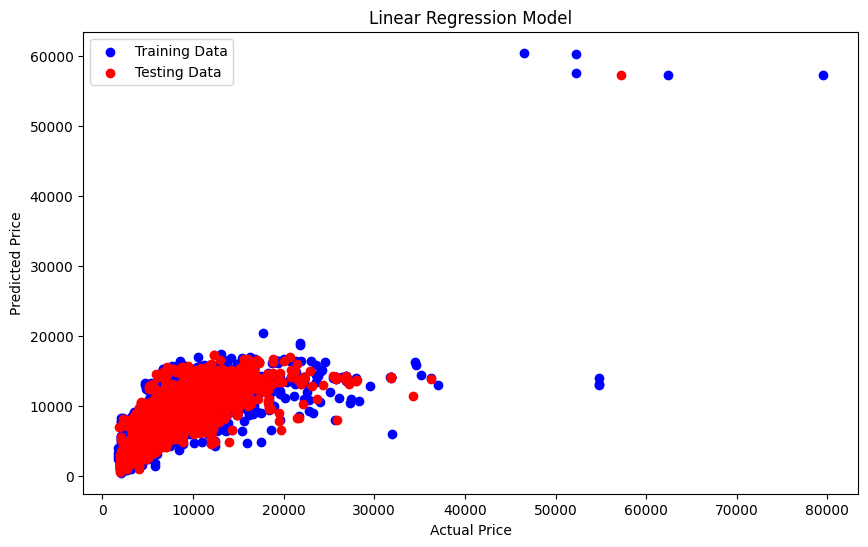

In [91]:
#LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Initialize Linear Regression model
linear_reg_model = LinearRegression()

# Train the model
linear_reg_model.fit(X_train, y_train)

# Predictions on training and testing data
train_predictions = linear_reg_model.predict(X_train)
test_predictions = linear_reg_model.predict(X_test)

# Calculate R^2 scores for training and testing data
train_r2_score = r2_score(y_train, train_predictions)
test_r2_score = r2_score(y_test, test_predictions)

# Convert R^2 scores to accuracy in percentage form
train_accuracy_percentage = train_r2_score * 100
test_accuracy_percentage = test_r2_score * 100

print(f'Training Accuracy (Linear Regression): {train_accuracy_percentage:.2f}%')
print(f'Testing Accuracy (Linear Regression): {test_accuracy_percentage:.2f}%')

# Plotting
plt.figure(figsize=(10, 6))

# Plotting training data
plt.scatter(y_train, train_predictions, color='blue', label='Training Data')

# Plotting testing data
plt.scatter(y_test, test_predictions, color='red', label='Testing Data')

plt.title('Linear Regression Model')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()
#Evaluation Metrics



In [92]:
#Evaluation Metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Relative Absolute Error (RAE)
def relative_absolute_error(y_true, y_pred):
    abs_err = np.abs(y_true - y_pred)
    return np.sum(abs_err) / np.sum(np.abs(y_true - np.mean(y_true)))

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    abs_percentage_err = np.abs((y_true - y_pred) / y_true)
    return np.mean(abs_percentage_err) * 100

# Root Mean Squared Error (RMSE)
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Relative Squared Error (RSE)
def relative_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) / np.mean((y_true - np.mean(y_true))**2)

# Normalized Root Mean Squared Error (NRMSE)
def normalized_root_mean_squared_error(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred) / (np.max(y_true) - np.min(y_true))

# Relative Root Mean Squared Error (RRMSE)
def relative_root_mean_squared_error(y_true, y_pred):
    return np.sqrt(relative_squared_error(y_true, y_pred))

# Calculate all metrics
rae = relative_absolute_error(y_test, test_predictions)
mape = mean_absolute_percentage_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
rmse = root_mean_squared_error(y_test, test_predictions)
rse = relative_squared_error(y_test, test_predictions)
nrmse = normalized_root_mean_squared_error(y_test, test_predictions)
rrmse = relative_root_mean_squared_error(y_test, test_predictions)

# Print the results

print(f'Relative Absolute Error (RAE): {rae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Relative Squared Error (RSE): {rse}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse}')
print(f'Relative Root Mean Squared Error (RRMSE): {rrmse}')


Relative Absolute Error (RAE): 0.5375147321653392
Mean Absolute Percentage Error (MAPE): 24.094412981776987
Mean Squared Error (MSE): 7839969.180595526
Root Mean Squared Error (RMSE): 2799.9944965295067
Relative Squared Error (RSE): 0.3905633105073183
Normalized Root Mean Squared Error (NRMSE): 0.05056971403726827
Relative Root Mean Squared Error (RRMSE): 0.6249506464572369


Training Accuracy (Polynomial Regression): 72.27%
Testing Accuracy (Polynomial Regression): 71.69%


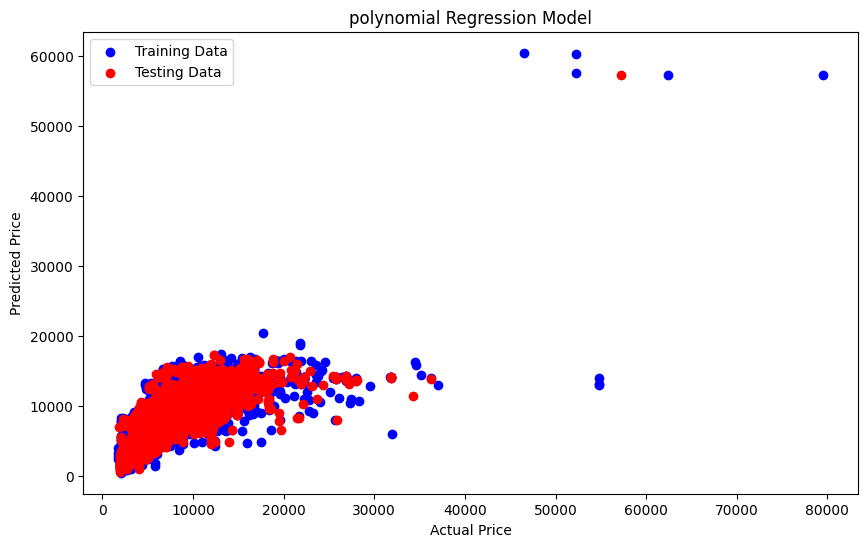

Relative Absolute Error (RAE): 0.47279162975134936
Mean Absolute Percentage Error (MAPE): 21.08394397759331
Mean Squared Error (MSE): 5681824.017501777
Root Mean Squared Error (RMSE): 2383.6576972169846
Relative Squared Error (RSE): 0.28305111243140385
Normalized Root Mean Squared Error (NRMSE): 0.04305040179914726
Relative Root Mean Squared Error (RRMSE): 0.5320254809982355


In [93]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures

# Initialize Polynomial Features
poly_features = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Generate polynomial and interaction features
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Initialize Polynomial Regression model
poly_reg_model = LinearRegression()

# Train the model
poly_reg_model.fit(X_train_poly, y_train)

# Predictions on training and testing data
train_predictions_poly = poly_reg_model.predict(X_train_poly)
test_predictions_poly = poly_reg_model.predict(X_test_poly)

# Calculate R^2 scores for training and testing data
train_r2_score_poly = r2_score(y_train, train_predictions_poly)
test_r2_score_poly = r2_score(y_test, test_predictions_poly)

# Convert R^2 scores to accuracy in percentage form
train_accuracy_percentage_poly = train_r2_score_poly * 100
test_accuracy_percentage_poly = test_r2_score_poly * 100

print(f'Training Accuracy (Polynomial Regression): {train_accuracy_percentage_poly:.2f}%')
print(f'Testing Accuracy (Polynomial Regression): {test_accuracy_percentage_poly:.2f}%')
# Plotting
plt.figure(figsize=(10, 6))

# Plotting training data
plt.scatter(y_train, train_predictions, color='blue', label='Training Data')

# Plotting testing data
plt.scatter(y_test, test_predictions, color='red', label='Testing Data')

plt.title('polynomial Regression Model')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()
# Calculate all metrics
rae = relative_absolute_error(y_test, test_predictions_poly)
mape = mean_absolute_percentage_error(y_test, test_predictions_poly)
mse = mean_squared_error(y_test, test_predictions_poly)
rmse = root_mean_squared_error(y_test, test_predictions_poly)
rse = relative_squared_error(y_test, test_predictions_poly)
nrmse = normalized_root_mean_squared_error(y_test, test_predictions_poly)
rrmse = relative_root_mean_squared_error(y_test, test_predictions_poly)

# Print the results

print(f'Relative Absolute Error (RAE): {rae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Relative Squared Error (RSE): {rse}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse}')
print(f'Relative Root Mean Squared Error (RRMSE): {rrmse}')

In [94]:
from sklearn.linear_model import Lasso

# Initialize Lasso Regression model
lasso_model = Lasso(alpha=0.1)

# Train the model
lasso_model.fit(X_train, y_train)

# Predictions on training and testing data
train_predictions_lasso = lasso_model.predict(X_train)
test_predictions_lasso = lasso_model.predict(X_test)

# Calculate R^2 scores for training and testing data
train_r2_score_lasso = r2_score(y_train, train_predictions_lasso)
test_r2_score_lasso = r2_score(y_test, test_predictions_lasso)

# Convert R^2 scores to accuracy in percentage form
train_accuracy_percentage_lasso = train_r2_score_lasso * 100
test_accuracy_percentage_lasso = test_r2_score_lasso * 100

print(f'Training Accuracy (Lasso Regression): {train_accuracy_percentage_lasso:.2f}%')
print(f'Testing Accuracy (Lasso Regression): {test_accuracy_percentage_lasso:.2f}%')

# Calculate all metrics
rae = relative_absolute_error(y_test, test_predictions_lasso)
mape = mean_absolute_percentage_error(y_test, test_predictions_lasso)
mse = mean_squared_error(y_test, test_predictions_lasso)
rmse = root_mean_squared_error(y_test, test_predictions_lasso)
rse = relative_squared_error(y_test, test_predictions_lasso)
nrmse = normalized_root_mean_squared_error(y_test, test_predictions_lasso)
rrmse = relative_root_mean_squared_error(y_test, test_predictions_lasso)

# Print the results

print(f'Relative Absolute Error (RAE): {rae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Relative Squared Error (RSE): {rse}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse}')
print(f'Relative Root Mean Squared Error (RRMSE): {rrmse}')


Training Accuracy (Lasso Regression): 61.11%
Testing Accuracy (Lasso Regression): 60.94%
Relative Absolute Error (RAE): 0.5374763549765791
Mean Absolute Percentage Error (MAPE): 24.090599714000135
Mean Squared Error (MSE): 7840560.9894129755
Root Mean Squared Error (RMSE): 2800.1001748889225
Relative Squared Error (RSE): 0.39059279261440394
Normalized Root Mean Squared Error (NRMSE): 0.05057162265688242
Relative Root Mean Squared Error (RRMSE): 0.6249742335603956


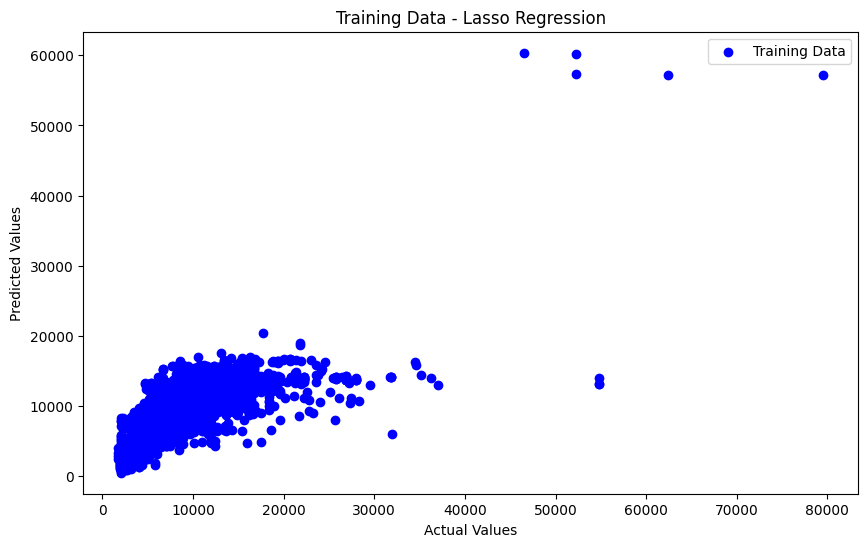

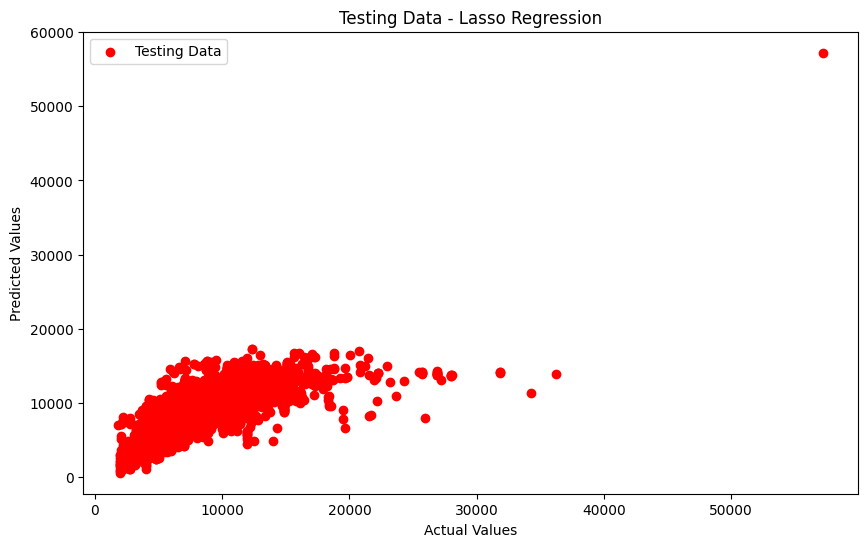

Training Accuracy (Lasso Regression): 61.11%
Testing Accuracy (Lasso Regression): 60.94%


In [95]:
import matplotlib.pyplot as plt

# Plot training data
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_predictions_lasso, c='blue', label='Training Data')
plt.title('Training Data - Lasso Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Plot testing data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions_lasso, c='red', label='Testing Data')
plt.title('Testing Data - Lasso Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

print(f'Training Accuracy (Lasso Regression): {train_accuracy_percentage_lasso:.2f}%')
print(f'Testing Accuracy (Lasso Regression): {test_accuracy_percentage_lasso:.2f}%')

In [96]:
from sklearn.linear_model import Ridge

# Initialize Ridge Regression model
ridge_model = Ridge(alpha=0.1)

# Train the model
ridge_model.fit(X_train, y_train)

# Predictions on training and testing data
train_predictions_ridge = ridge_model.predict(X_train)
test_predictions_ridge = ridge_model.predict(X_test)

# Calculate R^2 scores for training and testing data
train_r2_score_ridge = r2_score(y_train, train_predictions_ridge)
test_r2_score_ridge = r2_score(y_test, test_predictions_ridge)

# Convert R^2 scores to accuracy in percentage form
train_accuracy_percentage_ridge = train_r2_score_ridge * 100
test_accuracy_percentage_ridge = test_r2_score_ridge * 100

print(f'Training Accuracy (Ridge Regression): {train_accuracy_percentage_ridge:.2f}%')
print(f'Testing Accuracy (Ridge Regression): {test_accuracy_percentage_ridge:.2f}%')

# Calculate all metrics
rae = relative_absolute_error(y_test, test_predictions_ridge)
mape = mean_absolute_percentage_error(y_test, test_predictions_ridge)
mse = mean_squared_error(y_test, test_predictions_ridge)
rmse = root_mean_squared_error(y_test, test_predictions_ridge)
rse = relative_squared_error(y_test, test_predictions_ridge)
nrmse = normalized_root_mean_squared_error(y_test, test_predictions_ridge)
rrmse = relative_root_mean_squared_error(y_test, test_predictions_ridge)

# Print the results

print(f'Relative Absolute Error (RAE): {rae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Relative Squared Error (RSE): {rse}')
print(f'Normalized Root Mean Squared Error (NRMSE): {nrmse}')
print(f'Relative Root Mean Squared Error (RRMSE): {rrmse}')

Training Accuracy (Ridge Regression): 61.11%
Testing Accuracy (Ridge Regression): 60.94%
Relative Absolute Error (RAE): 0.5376094589499435
Mean Absolute Percentage Error (MAPE): 24.09884056477287
Mean Squared Error (MSE): 7840402.436455641
Root Mean Squared Error (RMSE): 2800.071862730605
Relative Squared Error (RSE): 0.3905848939905088
Normalized Root Mean Squared Error (NRMSE): 0.0505711113209667
Relative Root Mean Squared Error (RRMSE): 0.6249679143688168


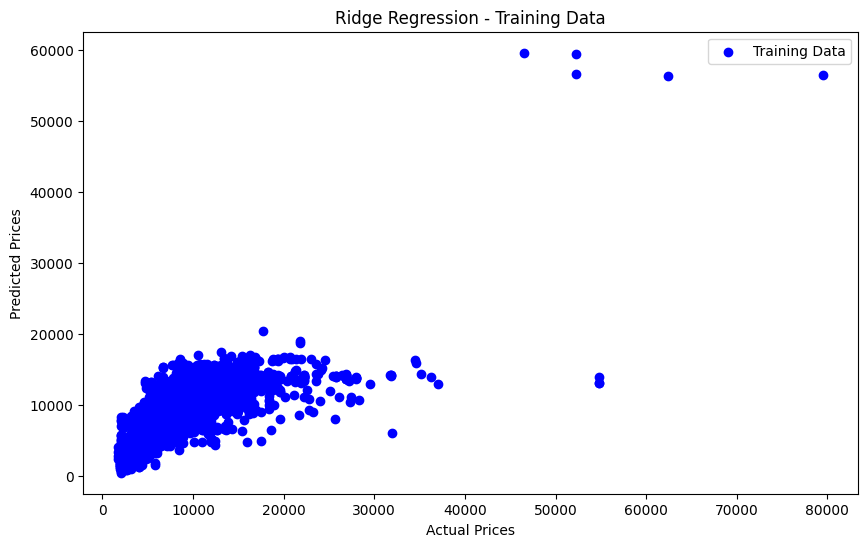

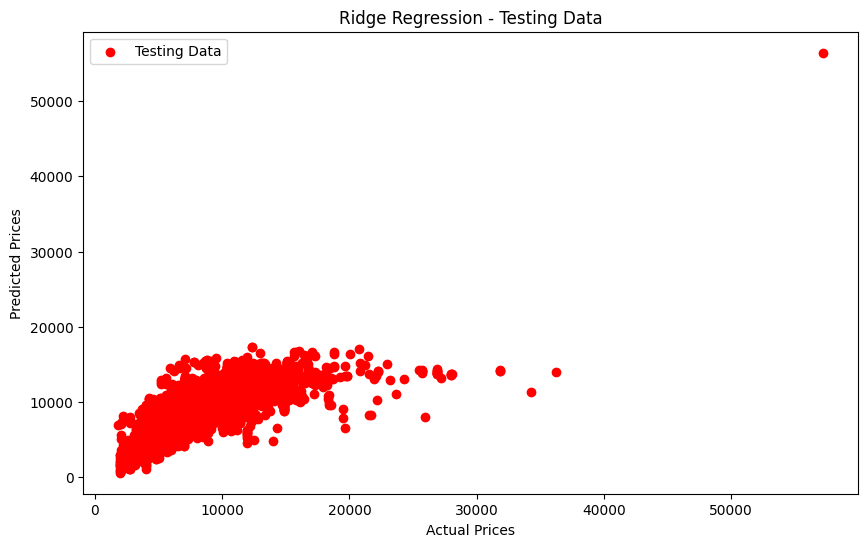

In [97]:


import matplotlib.pyplot as plt

# Plot training data
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_predictions_ridge, c='blue', label='Training Data')
plt.title('Ridge Regression - Training Data')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()

# Plot testing data
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions_ridge, c='red', label='Testing Data')
plt.title('Ridge Regression - Testing Data')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.show()

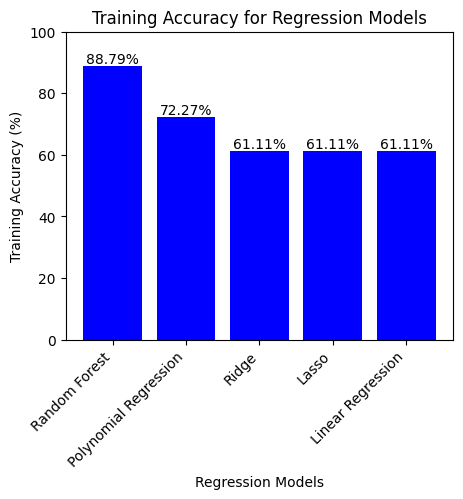

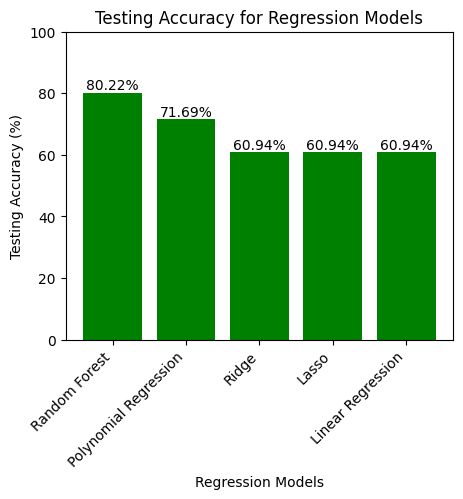

In [98]:
import matplotlib.pyplot as plt

# List of regression models
models = ["Random Forest",  "Polynomial Regression","Ridge", "Lasso", "Linear Regression"]
training_accuracy = 49.75
testing_accuracy = 54.42
# Training accuracy values
training_accuracy = [88.79,72.27,61.11,61.11,61.11]

# Testing accuracy values
testing_accuracy = [80.22,71.69,60.94,60.94,60.94]

# Create bar plot for training accuracy
plt.figure(figsize=(5,4))
plt.bar(models, training_accuracy, color='blue')
plt.xlabel('Regression Models')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy for Regression Models')
plt.ylim(0, 100)  # Set the y-axis limit to 0-100 for consistency

# Display the training accuracy values as labels on the bars
for i, acc in enumerate(training_accuracy):
    plt.text(i, acc, f"{acc:.2f}%", ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability

plt.show()
# Create bar plot for testing accuracy
plt.figure(figsize=(5,4))
plt.bar(models, testing_accuracy, color='green')
plt.xlabel('Regression Models')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracy for Regression Models')
plt.ylim(0, 100)  # Set the y-axis limit to 0-100 for consistency

# Display the testing accuracy values as labels on the bars
for i, acc in enumerate(testing_accuracy):
    plt.text(i, acc, f"{acc:.2f}%", ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability

plt.show()
